# Segment 1 - Intro

Before we start interpreting _why_ a vision model makes a decision, we need to understand _what kind of information_ flows through it. 

This project is not a CNN tutorial. Instead, the goal of this assignment is to build a **mental model** of how convolutional networks see images - because interpretability methods only make sense once that mental model is in place.

In this segment, we will explore four ideas:

1. How a CNN "sees" an image at first glance
2. How convolutional filters act as local pattern detectors
3. Why spatial locality and weight sharing matter
4. How deeper layers represent increasingly abstract features

We will use a pretained GoogleNet model and a single natural image to keep things concrete.

## 1️⃣ From pixels to tensors

A CNN never sees an image as a picture - it sees a **tensor of numbers**. Before anythign interesting happens, we need to load an image, normalize it, and pass it through a pretrained CNN. This step established the _input space_ the model operates in. 

c:\Users\joana\OneDrive\Documentos\GitHub\Vision-Interpretability\venv-lucent\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\joana\OneDrive\Documentos\GitHub\Vision-Interpretability\venv-lucent\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\joana/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:02<00:00, 23.7MB/s]


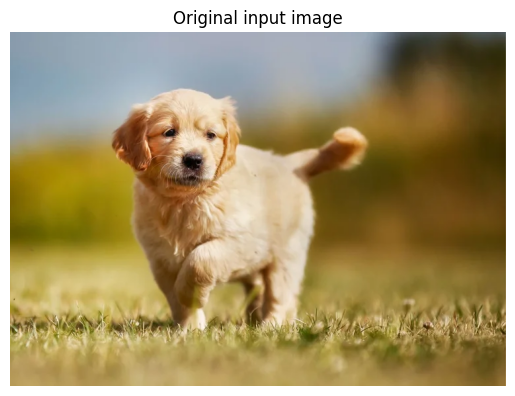

In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

# Load an image from a URL
url = "https://images.squarespace-cdn.com/content/v1/54e7a1a6e4b08db9da801ded/fdecc7f0-42bf-4696-bd4c-73a868e5d1d2/81.jpg?format=750w"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Image preprocessing (ImageNet standard)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_t = transform(img)

# Load pretrained GoogLeNet
model = models.googlenet(pretrained=True)
model.eval()

# Forward pass
output = model(img_t.unsqueeze(0))

plt.imshow(img)
plt.axis("off")
plt.title("Original input image")
plt.show()


The model does not know what a "dog" or a "face" is at this stage, it only receives local pixel intensities, normalized to match ImageNet statistics, and everything that follows is built on top of this raw numerical representation.

## 2️⃣ Early convolutional layers: local pattern detectors

The **first convolutional layers** in a CNN act like sliding detectors. Each filter looks at a small patch of the image, and the same filter is reused across all spatial locations (**weight sharing**). Each channel in the output corresponds to _one learned pattern_. 

To see this, we extract the activations of the **first** convolutional layer and visualize one channel.

Activation shape: torch.Size([1, 64, 128, 179])


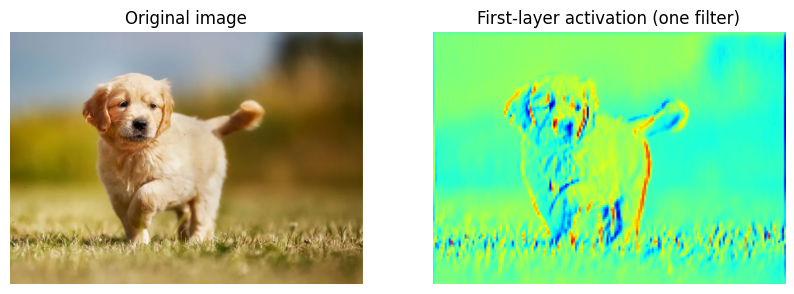

In [2]:
# Find the first convolutional layer
first_conv = None
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        first_conv = layer
        break

# Hook to capture activations
activations = []
def hook_fn(module, input, output):
    activations.append(output.detach())

first_conv.register_forward_hook(hook_fn)

# Run model again
_ = model(img_t.unsqueeze(0))
acts = activations[0]

print("Activation shape:", acts.shape)

# Visualize one channel
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(acts[0, 24].cpu(), cmap="jet")
plt.axis("off")
plt.title("First-layer activation (one filter)")
plt.show()


**What we're seeing**: The bright regions correspond to places whe're the filter "fired" strongly. These filters often correspond to edges, color contrasts and simple textures. Can you guess what this filter is reacting to?

A convolutional layer does not detect objects. It detects repeated local patterns, everywhere in the image, using the same weights.

## 3️⃣ Deeper layers: from patterns to parts

As we go deeper into the network, receptive field grow, activations become less tied to exact pixels and features combine into moe abstract structures.

We can repeat the same experiment for the **last** convolutional layer and compare.

Activation shape: torch.Size([1, 128, 8, 11])


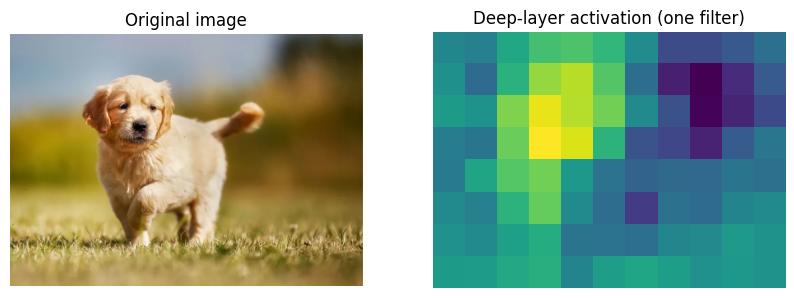

In [3]:
# Find the last convolutional layer
last_conv = None
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        last_conv = layer

# Hook
activations = []
last_conv.register_forward_hook(hook_fn)

# Forward pass
_ = model(img_t.unsqueeze(0))
acts = activations[-1]

print("Activation shape:", acts.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(acts[0, 35].cpu(), cmap="viridis")
plt.axis("off")
plt.title("Deep-layer activation (one filter)")
plt.show()

**What changed?**: The activation map is of a lower resolution because the filter iterates over a larger, it's more spatially diffuse and less obviously tied to edges of colors. This gradual abstraction is why interpretability often focuses on specific layers - each layer represents a different level of meaning.

This channel specifically detect dog faces! Feel free to plug dog images into the piece of code above. You'll see the brightest activated regions will correspond to the dog's face.

## 4️⃣ What does a neuron “want to see”?

Instead of showing the model an image and seeing how it reacts, we can ask the model directly: _what kind of input would maximally activate this neuron_? This is a core question in interpretability, and libraries like **Lucent** make it easy. 

Here, we visualize what a **single channel** in an intermediate layer is looking for

100%|██████████| 512/512 [01:30<00:00,  5.68it/s]


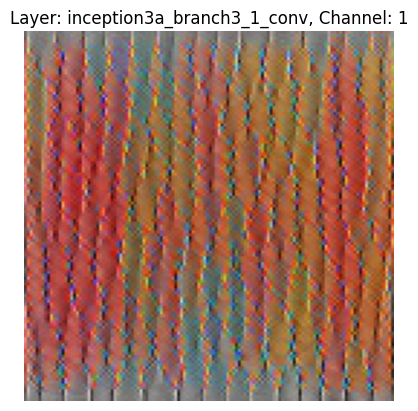

In [4]:
import lucent
from lucent.optvis import render, param, objectives

model = models.googlenet(pretrained=True)
model.eval()

layer = "inception3a_branch3_1_conv"
channel = 1

objective = objectives.channel(layer, channel)
param_f = lambda: param.image(128)

images = render.render_vis(model, objective, param_f)

plt.imshow(images[0][0, :, :, :3])
plt.axis("off")
plt.title(f"Layer: {layer}, Channel: {channel}")
plt.show()

**Why this matters**: This image is _not_ from the dataset, it is synthetically generated to excite one neuron. It reveals the kind of structure the neuron responds to and the level of abstraction at that layer.

The idea of neurons as _feature detectors_ will reapper throughout the rest of the project.

## 🧩 Takeaways from Segment 1

By now, we've seen that:
- CNNs process images as hierarchies of representations
- Convolutional filters detect local, reusable patterns
- Deeper layers encode more abstract concepts
- Interpretability depends on _which layer_ we inspect

With this mental model in place, we're ready to move on from _what the network sees_ to _why it makes specific decisions_, which is where interpretability is most interested in. 